<div style="text-align: center; font-weight: bold; font-size: 200%"> Modèle épidimiologique - covid-19</div>                                                        
<br />      
<div style="text-align: center; font-size: 150%">Projet MAP 568 - Ecole polytechnique</div><br />  
<div style="text-align: center; font-size: 120%">Calot Paul et Nagaev Sacha</div><br />  

Le modèle est définit dans [model](model.py#SEIR). De nombreuses variables et fonctions utilisées dans la suite sont définies dans [utils](utils.py). Nous attirerons l'attention au moment opportun sur les différences fonctions.

In [1]:
# my modules imports
    # Model
from model import SEIR
from model import f, f_manual

    # utils
from utils import init_date, delta_time
from utils import draw_input_params, nb_inputs
from utils import extract_int_value, get_max_load_intensive_care
from utils import idx_to_keys, key_to_idx, input_params, ykeys, box_colors, plotting_names
from utils import Monte_Carlo_sampling, lhs

    # plotting
from utils_plotting import plot_hist, plot_morris, plot_sobol, plot_sobol_time

# other imports
from pprint import pprint
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend, ColumnDataSource, Label, LabelSet, Range1d
from bokeh.palettes import magma, viridis
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider


In [2]:
debug = True
seed = 1111

## Définition du Modèle

La classe *SEIR* importée du module [model](model.py) est utilisée pour créer le modèle épidémiologique à partir d'un tirage aléatoire du vecteur d'entrée $\vec{X}$ grâce à la fonction [draw_input_params](utils.py) qui prend en argument le *seed* et est définit dans [utils](utils.py), envoyé à la fonction *numpy.random.seed* par défaut :
```python
seed = None
np.random.seed(seed)
```

Dans la cellule suivante, on initialise un modèle, puis on le *print* en utilisant une [fonction](model.py) définit à l'intérieur de la classe *SEIR* avant d'effectuer un [pas "manuel"](model.py). Nous verrons que pour ce qui suit, nous utilisons exclusivement la fonction *odeint* du module *scipy.integrate* pour réaliser l'intégration du modèle.

Pour simplier également, plusieurs dictionnaires sont utilisés tout au long du *notebook* : 
```python

idx_to_keys = {
    0 : 'pa',
    1 : 'pIH',
    2 : 'pIU',
    3 : 'pHD',
    4 : 'pHU',
    5 : 'pUD',
    6 : 'NI',
    7 : 'NH',
    8 : 'NU',
    9 : 'R0',
    10 : 'mu',
    11 : 'N',
    12 : 't0',
    13 : 'Im0',
    14 : 'lambda1'
}

key_to_idx = {v : k for k, v in idx_to_keys.items()}

# bounds
input_params = {
    'pa': [0.4,0.9],
    'pIH' : [0.05, 0.2],
    'pIU' : [0.01, 0.04],
    'pHD' : [0.1, 0.2],
    'pHU' : [0.1,0.2],
    'pUD' : [0.2, 0.4],
    'NI' : [8.0, 12.0],
    'NH' : [15.0,25.0],
    'NU' : [10., 20.],
    'R0' : [2.9, 3.4],
    'mu' : [0.01, 0.08],
    'N' : [4*7+3, 7*7+3],
    't0' : [0, 4*7+3],
    'Im0' : [1., 100.],
    'lambda1' : [1e-4, 1e-3]
}
```

In [3]:
if(debug):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    model.step(dt = 1.0) # dt in days 
    model.prettyprint()

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.44777459960438104),
             ('pIH', 0.18875055527924495),
             ('pIU', 0.020307202696216567),
             ('pHD', 0.13104769418698442),
             ('pHU', 0.10020098399490976),
             ('pUD', 0.2471189448783151),
             ('NI', 8.951166880633519),
             ('NH', 22.359158732407092),
             ('NU', 14.954680759619642),
             ('R0', 3.2922126744045577),
             ('mu', 0.018855441784553242),
             ('N', 49),
             ('t0', 10),
             ('Im0', 47.1459765189812),
             ('lambda1', 0.0003134189119522501)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.09881985306407182),
             ('gIH', 0.011644610401521123),
             ('gIU', 0.0012528146653254559),
             ('gHD', 0.005861029735302406),
             ('gHU', 0.004481429073164532),
             ('gHR', 0.03438194303365658),
            

Les fonctions suivantes permettent de réaliser, à partir d'un vecteur d'entrée $\vec{X}$ la simulation d'un modèle sur une période de temps donné. Nous utilisons la fonction [extract_int_value](utils.py), qui extrait les valeurs des jours entiers de la solutions renvoyée.
```python
def extract_int_value(solution, step_in_day):
    sol, period = (solution[::int(1/step_in_day),:], 1) if step_in_day < 1 else (solution, step_in_day) # extraction of integer day value
    return sol, period # period = 1, if we have a value for each day, if one value every two days, equals 2 etc.
```

En pratique, dans le cas où on utilise un pas de temps $p$ inférieur au jour, il est nécessaire que $\frac{1}{p}$ soit entier.

```python

def f(input_params, step_in_day = 0.1, tend = 300.0, verbose = False):
    model = SEIR(input_params)
    
    if(verbose):
        model.prettyprint()
        
    fcn = model.get_fcn()
    y_ini = model.get_state()

    # in number of days
    tini = input_params[key_to_idx['t0']]
    tend = tini+tend # in days
    number_of_steps = int((tend-tini)/step_in_day)
    
    t_simu = np.linspace(tini,tend,number_of_steps)
    
    rtol, atol = 1e-3, 1e-6 # default values
    solution = odeint(func = fcn, t = t_simu, y0 = y_ini) 
    
    sol, period = extract_int_value(solution, step_in_day)

    return sol,  period
```

## Q1) Afficage de la solution

Nous définissons ici une fonction permettant de réaliser l'affichage d'une solution via le packet *bokeh*. On utilise la fonction [get_max_load_intensive_care](utils.py) qui retourne la valeur du maximum de *U*, où le nombre de personnes en soin intensif, ainsi que le temps auquel cette valeur est atteinte. 

Nous faisons également appel à [box_colors](utils.py) et [plotting_names](utils.py) qui définissent les couleurs et noms d'affichage des différentes boîtes.

```python
plotting_names = {
    'S' : 'Susceptible (S)',
    'Im' : 'Infec. not Detec. (I-)',
    'Ip' : 'Infec. Detec. (I+)',
    'Rm' : 'Recov. not Detec. (R-)',
    'RI' : 'Recov. Detec. (R+)',
    'H' : 'Hospital (H)',
    'U' : 'Intensive care (U)',
    'RH' : 'Recov. Hosp. (R+H)',
    'D' : 'Dead (D)',
    'DR' : 'Detected (DR)'
}
box_colors = {
    'S' : 'yellow',
    'Im' : 'purple',
    'Ip' : 'orange',
    'Rm' : 'olive',
    'RI' : 'olivedrab',
    'H' : 'lightblue',
    'U' : 'pink',
    'RH' : 'darkolivegreen',
    'D' : 'red',
    'DR' : 'blue'
}
```

In [4]:
def plot_solution(seed = None, do_manually = False, verbose = False):
    x = draw_input_params(seed)
    tini = x[key_to_idx['t0']]
    tend = 200.0
    
    sol, period = f(x, tend = tend)
    
    times = [init_date+delta_time*tini+k*period*delta_time for k in range(int(tend))]
    
    sum_all = sol[:,:-1].sum(axis=1)
    max_time, max_U = get_max_load_intensive_care(sol, period)
    
    print('Max intensive care load at days {} with {} patients.'.format(max_time, max_U))
    
    if(do_manually):
        sol_bis, period_bis = f_manual(x, tend = tend)
        
        times_ = [init_date+delta_time*tini+k*period_bis*delta_time for k in range(int(tend))]

        max_time_, max_U_ = get_max_load_intensive_care(sol_bis, period_bis)
        
        print('MANUAL : Max intensive care load at days {} with {} patients.'.format(max_time_, max_U_))

    fig_sol = figure(plot_height=450, plot_width=900, title="Solution", x_axis_type='datetime')
    
    legend_it = []

    for idx, (key, name) in enumerate(plotting_names.items()):
        c = fig_sol.x(times, sol[:,idx], line_width=1, color = box_colors[key], alpha=0.9, muted_color=box_colors[key], muted_alpha=0.01) # legend_label="Speed")
        if(do_manually):
            c_ = fig_sol.line(times_, sol_bis[:,idx], line_width=1, color = box_colors[key], alpha=0.9, muted_color=box_colors[key], muted_alpha=0.01) # legend_label="Speed")
            legend_it.append((name, [c,c_]))
        else:
            legend_it.append((name, [c]))
    c = fig_sol.x(times,sum_all, line_width=1, color = 'black', alpha=0.9, muted_color="black", muted_alpha=0.01) # legend_label="Speed")
    legend_it.append(('Sum', [c]))

    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    fig_sol.add_layout(legend, 'right')

    show(fig_sol, notebook_handle=True)
    

In [5]:
plot_solution(seed = seed, do_manually = False)

Max intensive care load at days 77 with 305516 patients.


# Q2) 
Pour cette deuxième question, on fait appel à [draw_input_params](utils.py) avec à chaque fois ```seed = None```.

La fonction ci-dessous *Monte_Carlo_Umax* permet de réaliser le tirage de $N$ échantillons et d'obtenir les valeurs de $U_{max}$ et $T(U_{max})$ résultants via [get_max_load_intensive_care](utils.py). 

In [6]:
def Monte_Carlo_Umax(N = 100):
    list_U = []
    list_times = []
    
    for k in range(N): 
        x = draw_input_params()
        model = SEIR(x)

        fcn = model.get_fcn()
        y_ini = model.get_state()
        
        step_in_day = 0.1 # 0.1 : 10 points per day
        tini = 0.
        tend = 200.0
        number_of_steps = int((tend-tini)/step_in_day)

        t = np.linspace(tini,tend,number_of_steps)

        rtol, atol = 1e-3, 1e-6 # default values
        
        solution = odeint(func = fcn, t = t, y0 = y_ini)
    
        sol, period = extract_int_value(solution, step_in_day)
        max_time, max_U = get_max_load_intensive_care(sol, period)
        list_U.append(max_U)
        list_times.append(max_time)
    
    return np.array(list_U), np.array(list_times)

In [7]:
N=200
list_U, list_times = Monte_Carlo_Umax(N=N)

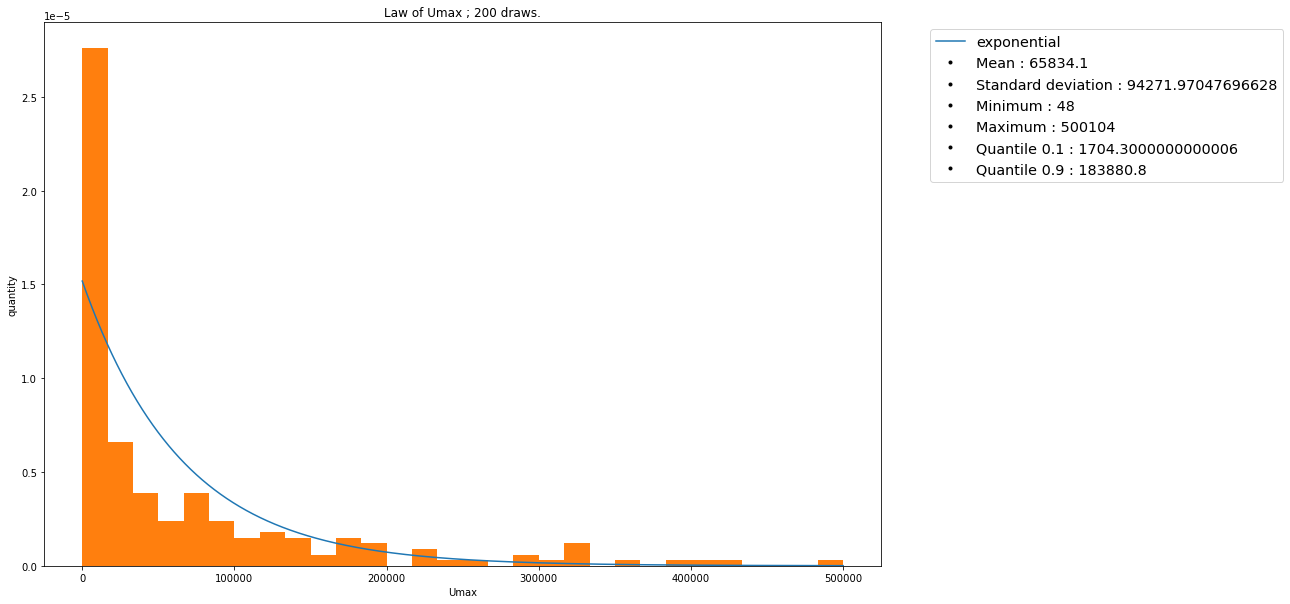

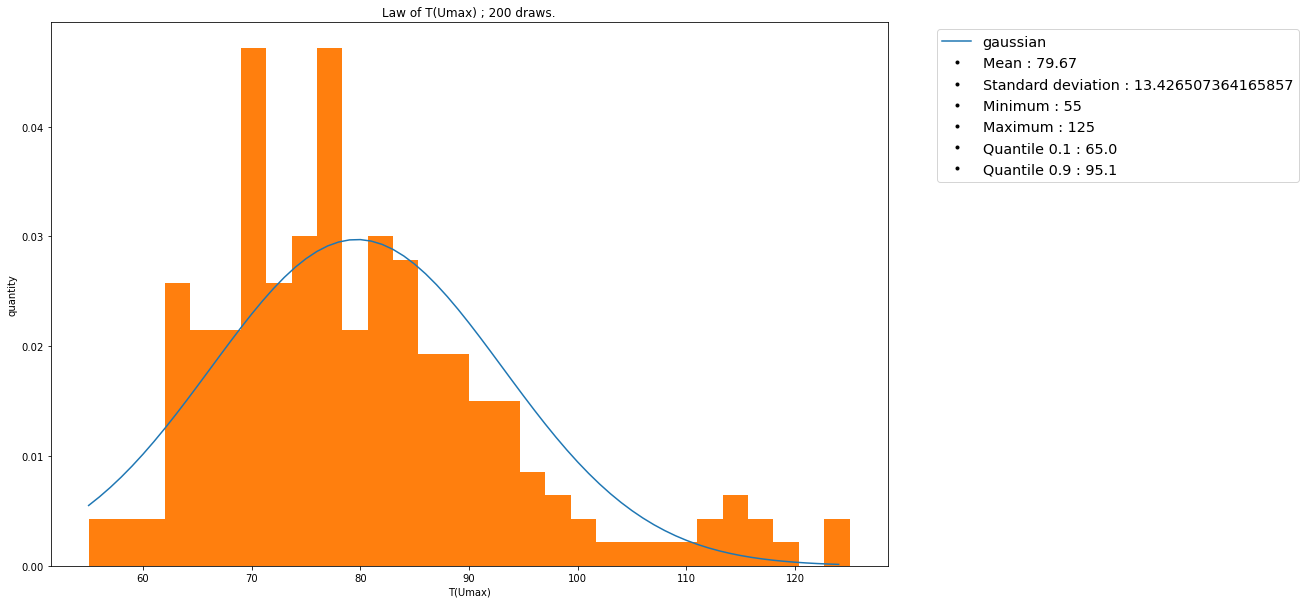

In [8]:
from scipy.stats import chi2, norm, poisson, expon
bins = 30

# Defintion of a given number of law if we want to try to find one that suits the data
gaussian_pdf = lambda x, mean, std : norm.pdf(x=x, loc = mean, scale = std)
exponential_pdf = lambda x, mean, std : expon.pdf(x=x, loc=0, scale=mean) # scale = 1/lambda = Esp(U)
chi2_k1_pdf = lambda x, mean, std : chi2.pdf(x=x, df=1, loc=0, scale=mean) # df : degrees of freedom 
poisson_pmf = lambda x, mean, std : poisson.pmf(x, mu = mean, loc=0)

plot_hist(list_U, bins = bins, name = 'Umax', law = exponential_pdf, name_law = 'exponential', savefig = 'law_Umax')
plot_hist(list_times, bins = bins, name = 'T(Umax)', law = gaussian_pdf, name_law = 'gaussian', savefig = 'law_T(Umax)')

## Q3) Méthode de Morris - première méthode

Dans un premier temps nous avons essayé de coder nous-même la méthode de Morris et de Sobol le plus simplement possible : différences finies pour calculer le gradient par exemple.

Nous avons choisi de vous présenter d'abord ces résultats. Vous pouvez vous référez à [sensitivy_analysis_by_hands](sensitivy_analysis_by_hands.py) pour les fonctions réalisées que nous utilisons ici.

In [9]:
from sensitivy_analysis_by_hands import  Morris

# if you want only one of the two you can use get_U or get_T instead of get_max_load_intensive_care
get_U = lambda arr, period : get_max_load_intensive_care(arr, period)[1]
get_T = lambda arr, period : get_max_load_intensive_care(arr, period)[0]

In [10]:
mu_arr, sigma_arr = Morris(fn = get_max_load_intensive_care, h = 2, R = 20, delta = 1e-6, method = 'lhs')
# pa,NI,R0,μ,N,t0,I0−

In [11]:
print('Umax : ')
plot_morris(mu_arr[1], sigma_arr[1], names = 'default')

Umax : 


In [14]:
print('T(Umax) : ')
plot_morris(mu_arr[0], sigma_arr[0], names = 'default')


T(Umax) : 


### Q4) Analyse de sensiblité de Sobol - première méthode
Ici encore, nous donnons les résultats obtenus par les algorithmes implémentés que nous avons implémentés.

Vous pouvez vous référez à [sensitivy_analysis_by_hands](sensitivy_analysis_by_hands.py) pour la fonction Sobol que nous utilisons ici.


In [20]:
from sensitivy_analysis_by_hands import Sobol

In [21]:
S, St = Sobol(fn = get_max_load_intensive_care, R = 200, method = 'MC')

In [22]:
# plot_sobol(S[:,0],St[:,0])
plot_sobol(S[idxes,0],St[idxes,0], names = names)

In [24]:
# plot_sobol(S[:,1],St[:,1])
plot_sobol(S[idxes,1],St[idxes,1], names = names)

### Q3) Analyse de Morris - via *SALib*

Au vu des résultats que nous obtenions, principalement concernant la méthode de Morris, nous avons cherché des solutions alternatives. Nous utisons ici le package *SALib* de *Python*.

In [29]:
# Morris 
from SALib.sample import morris as morris_
from SALib.analyze import morris
from utils import lhs

# Define the model inputs
names = list(idx_to_keys.values())
bounds = list(input_params.values())

# Definition of the problem
problem = {
    'num_vars': 15,
    'names': names,
    'bounds': bounds
}

# SALib requires arrays of type float.
fn = lambda x: get_max_load_intensive_care(*f(x, step_in_day = 0.1, tend = 200.0)) # T(Umax)

def eval_fn(X):
    TU,U = [], []
    for x in X:
        tu, u = fn(x)
        TU.append(tu)
        U.append(u)
    return np.array(TU, dtype = float), np.array(U, dtype = float)

In [30]:
Xm = morris_.sample(problem, 100, num_levels=4) # lhs(1600) 
YmT, Ym = eval_fn(Xm)

In [31]:
# Morris analysis on T(Umax)
MT = morris.analyze(problem, Xm.astype(float), YmT.astype(float), conf_level=0.95, \
                    print_to_console=False, num_levels=4)


In [32]:
# Morris analysis on Umax
M = morris.analyze(problem, Xm.astype(float), Ym.astype(float), conf_level=0.95, \
                    print_to_console=False, num_levels=4)

In [33]:
print('Umax : ')
plot_morris(M['mu_star'], M['sigma'], names = 'default')

Umax : 


In [34]:
print('T(Umax) : ')
plot_morris(MT['mu_star'],MT['sigma'],  names = 'default')

T(Umax) : 


### Q4) Analyse de Sobol - via *SALib*
L'analyse de Sobol se ramène ici à définir le problème et calculer les sorties du code à partir des échantillons choisis pour envoyer ensuite à *sobol.analyse* qui réalise le travail.

In [35]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

In [36]:
# Generate samples
param_values = saltelli.sample(problem, 100)
# Run model (example)
YT, Y = eval_fn(param_values)

In [37]:
# Perform analysis
Si_T = sobol.analyze(problem, YT, print_to_console=False)
Si = sobol.analyze(problem, Y, print_to_console=False)

In [38]:
plot_sobol(Si['S1'],Si['ST'])
plot_sobol(Si_T['S1'],Si_T['ST'])

## Q5) By Hands

In [39]:
# indexes that we are interested into
names = ['pa','NI','R0','mu','t0','Im0']
idxes = [key_to_idx[n] for n in names]

In [40]:
def HUDRH(sol, period):
    # order : S, Im, Ip, Rm, RI, H, U, RH, D, DR
    return np.transpose(sol[1:, [ykeys['H'],ykeys['U'],ykeys['D'],ykeys['RH']]])

S, St = Sobol(fn = HUDRH, R = 200, method = 'MC')

In [41]:
for idx, s in enumerate(['H','U','D','RH']):  
    print('{:-^100}'.format(' '+s+' '))
    plot_sobol_time(S[idxes,idx,:],St[idxes,idx,:], names = names)

------------------------------------------------ H -------------------------------------------------


------------------------------------------------ U -------------------------------------------------


------------------------------------------------ D -------------------------------------------------


------------------------------------------------ RH ------------------------------------------------


## Q6)

In [29]:
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import timedelta, date, datetime

In [30]:
path = 'data/donnees-hospitalieres-covid19-2021-03-01-19h03.csv'
#path = 'data/donnees-hospitalieres-nouveaux-covid19-2021-03-11-17h03.csv'
path_dr = 'data/data_dr.csv'

delta_time = timedelta(days = 1)
min_start = datetime(year = 2020, month = 2, day = 21) 
start = datetime(year = 2020, month = 2, day = 25) # start of the data on DR
first_lockdown = datetime(year = 2020, month = 3, day = 18) # date that we can use to get better results
end_simulation = datetime(year = 2020, month = 3, day = 31) # 31/03
end_value =  datetime(year = 2020, month = 5, day = 11) # end lockdown
list_of_times = [min_start+k*delta_time for k in range((end_value-min_start+delta_time).days)]

type(start)

datetime.datetime

In [31]:
len(list_of_times)

81

In [32]:
def convert_data(path, path_dr, end_date = '2020-05-11', end_date_DR = '11/05', start_date = None, end_date_f = None):
    # all
    df = pd.read_csv(path, sep = ';', header=0, parse_dates = ['jour'])
    df = df.loc[df['sexe']== 0]
    df = df.groupby(by = ['jour']).sum()
    result = np.where(df.index==end_date)[0]
    assert(len(result)==1)
    df=df[:result[0]+1]
    
    # DR
    df_dr = pd.read_csv(path_dr, sep = ',', header=0)
    result = df_dr[df_dr['date']==end_date_DR].index.values[0]
    df_dr=df_dr[:result+1]
    dr = df_dr['nbre'].values
    dr[1:] -= dr[:-1]
    
    nb_to_add = len(dr) - len(df)
    a = np.empty((nb_to_add))
    a[:] = np.nan
    H = np.concatenate([a, df['hosp'].values])
    U = np.concatenate([a, df['rea'].values])
    D = np.concatenate([a, df['dc'].values])
    R = np.concatenate([a, df['rad'].values])

    mon_dico = {
        'date' : list_of_times,
        'H' : H,
        'U' : U,
        'RH' : R,
        'D' : D,
        'DR' : dr
    }
    df = pd.DataFrame.from_dict(mon_dico)
    if(start_date != None):
        if(end_date_f != None):
            mask = (df['date'] >= start_date) & (df['date'] <= end_date_f)
        else:
            mask = df['date'] >= start_date

        df = df.loc[mask]
        #df = df[]
    return df

In [33]:
values = convert_data(path, path_dr, start_date = first_lockdown, end_date_f = end_simulation)
values

,date,H,U,RH,D,DR
26,2020-03-18,2972.0,771.0,816.0,218.0,1404
27,2020-03-19,4073.0,1002.0,1180.0,327.0,1861
28,2020-03-20,5226.0,1297.0,1587.0,450.0,1617
29,2020-03-21,5900.0,1453.0,1811.0,525.0,1847
30,2020-03-22,6954.0,1674.0,2117.0,632.0,1559
31,2020-03-23,8673.0,2080.0,2567.0,860.0,3838
32,2020-03-24,10163.0,2503.0,3281.0,1100.0,2446
33,2020-03-25,12072.0,2935.0,4085.0,1388.0,2928
34,2020-03-26,13879.0,3351.0,4947.0,1696.0,3925
35,2020-03-27,15701.0,3758.0,5698.0,1995.0,3809


In [34]:
def plot_data(values, pred = None):
    p = figure(plot_height=450, plot_width=900, x_axis_type='datetime')
    p.x(values['date'], values['H'], color=box_colors['H'], alpha=1, size=10, legend_label = 'H',  muted_color=box_colors['H'], muted_alpha=0.01)
    p.x(values['date'], values['U'], color=box_colors['U'], alpha=1, size=10,legend_label = 'U', muted_color=box_colors['U'], muted_alpha=0.01)
    p.x(values['date'], values['D'], color=box_colors['D'], alpha=1, size=10,legend_label = 'D', muted_color=box_colors['D'], muted_alpha=0.01)
    p.x(values['date'], values['RH'], color=box_colors['RH'], alpha=1,size=10, legend_label = 'RH', muted_color=box_colors['RH'], muted_alpha=0.01)
    p.x(values['date'], values['DR'], color=box_colors['DR'], alpha=1, size=10,legend_label = 'DR', muted_color=box_colors['DR'], muted_alpha=0.01)
        
    if(pred != None):
        p.line(pred['date'], pred['H'], line_width=1,color=box_colors['H'], alpha=1)
        p.line(pred['date'], pred['U'], line_width=1,color=box_colors['U'], alpha=1)
        p.line(pred['date'], pred['D'], line_width=1,color=box_colors['D'], alpha=1)
        p.line(pred['date'], pred['RH'], line_width=1,color=box_colors['RH'], alpha=1)
        p.line(pred['date'], pred['DR'], line_width=1,color=box_colors['DR'], alpha=1)
        
    p.legend.location = "top_left"
    p.legend.click_policy = "mute"
    
    show(p)

In [35]:
plot_data(values)

# Q7)

In [36]:
from scipy.optimize import minimize
from datetime import datetime

min_start = init_date # init_date
end_simulation = datetime(year = 2020, month = 3, day = 31) # 31/03
dt_day_max = (end_simulation-min_start).days

In [37]:
def fun(x, target, dt = 1.0, data_start = first_lockdown, t_end = end_simulation, select = ['H','U','RH','D','DR'], verbose = False):
    debug=False
    t_ini = init_date+x[key_to_idx['t0']]*delta_time
    span_simu = (end_simulation-t_ini).days+1
    if(verbose):
        print('Init date : {} - simulation spanning {} days'.format(t_ini, span_simu))
        
    sol, period = f(x, step_in_day = dt, tend = span_simu)
    
    days_before_data = (data_start-t_ini).days
    
    if(verbose):
        print('Time before allowing comparison between data : {}'.format(days_before_data))
    
    idxes = [ykeys[n] for n in select]
    if(days_before_data<0):
        l = len(target)
        target = target[-days_before_data:,:]
        data_start_ = data_start + (l-len(target))*delta_time
        data_start_bis = t_ini
        sol = sol[:,idxes] # all times but only select indexes

    else:
        data_start_ = data_start
        l=len(sol)
        sol = sol[days_before_data:,idxes] # all times but only select indexes
        data_start_bis = t_ini+(l-len(sol))*delta_time
    pred = sol
    
    if(debug):
        print('Comparing : {} vs {} - end : {}'.format(data_start, data_start_bis ,data_start + len(target)*delta_time))
        
    return least_squared(pred, target)

def least_squared(pred, target):
    eps = 1e-10
    residuals = ((pred-target)/np.sqrt(pred+eps))**2
    return np.sum(np.where(residuals == residuals, residuals, 0))

In [38]:

def contraints(x):
    N = x[key_to_idx['N']]
    t0 = x[key_to_idx['t0']]

    return np.array([N-int(N), t0 - int(t0)])
    
cons = {'type':'eq', 'fun': contraints}


In [39]:
x0 = draw_input_params()  # draw_input_params()
target = values.values[:,1:] # values.values[:dt_day_max,1:] # not taking datetime
bounds = input_params.values()
print(target.shape)

(14, 5)


In [40]:
launches = 200
err_min = np.inf
x_best = None
for k in range(launches):
    x0 = draw_input_params()
    argmin = minimize(fun, x0, args=(target), bounds=bounds, constraints=cons)
    err = argmin.fun
    if(err < err_min):
        x_best = argmin.x
        err_min = err

print(err_min)

/home/paul/anaconda3/envs/map568/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


7812.6283151841335


In [41]:
t_ini = init_date+x_best[key_to_idx['t0']]*delta_time
span_simu = (end_value-t_ini).days
sol, period = f(x_best, step_in_day = 1, tend = span_simu)
pred_dict = {
    'date': [t_ini+k*delta_time for k in range(span_simu)],
    'H' : sol[:,ykeys['H']],
    'U' : sol[:,ykeys['U']],
    'RH' : sol[:,ykeys['RH']],
    'D' : sol[:,ykeys['D']],
    'DR' : sol[:,ykeys['DR']]
}

In [42]:
plot_data(values, pred_dict)

In [43]:
for k, p in enumerate(x_best):
    param = input_params[idx_to_keys[k]]
    print('{} < {} < {}'.format(param[0],p,param[1]))

0.4 < 0.506495676522011 < 0.9
0.05 < 0.14110217924029314 < 0.2
0.01 < 0.037359346465577356 < 0.04
0.1 < 0.13605429219657217 < 0.2
0.1 < 0.16921440947524977 < 0.2
0.2 < 0.30047822860752105 < 0.4
8.0 < 9.059228102538825 < 12.0
15.0 < 19.183637512829698 < 25.0
10.0 < 10.231935679033093 < 20.0
2.9 < 3.1168393834555292 < 3.4
0.01 < 0.027271267833544735 < 0.08
31 < 46.0 < 52
0 < 16.0 < 31
1.0 < 21.239639550207407 < 100.0
0.0001 < 0.0006836960195209668 < 0.001
